### Monitoring wetland dynamics and its impact on malaria in the Zambesi delta, Mozambique

#### Context
What are wetlands?, why important?  
Why monitor?  
Relationship to malaria? Why it matters?  

### Method Description
1. Tasselled-Cap Wetnees (TCW) from surface reflectance
2. Fractional Cover
3. Masking using WOfS and TCW
4. Stacking and classifying the dominant land type
5. Comparison to malaria incidence rate 

#### 1. Tasseled-Cap Wetness(TCW) computaion from surface reflectance
TCW is one of the Tasseled-Cap Transform (TCT) indices, which uses a linear combination of Landsat bands to detect moisture content in soil and vegetation. The equations vary by Landsat sensor:

Landsat 5 & 7 (TM) Coefficients  
TCW=0.1509B1+0.1973B2+0.3279B3+0.3406B4−0.7112B5−0.4572B7  
Landsat 7 (ETM+) Coefficients  
TCW=0.2626B1+0.2141B2+0.0926B3+0.0656B4−0.7629B5−0.5388B7  
Landsat 8 & 9 (OLI) Coefficients  
TCW=0.1511𝐵2+0.1973𝐵3+0.3283𝐵4+0.3407𝐵5−0.7117𝐵6−0.4559𝐵7  
TCW=0.1511B2+0.1973B3+0.3283B4+0.3407B5−0.7117B6−0.4559B7  

B1, B2, etc., are Landsat bands (Surface Reflectance)

TCW is sensitive to water content in soil and vegetation

Higher TCW means more moisture, lower TCW means drier surfaces

In [2]:
import datacube
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map

In [3]:
#connect to datacube
dc = datacube.Datacube(app="Landsat_Surface_Reflectance")

In [3]:
# List Landsat products available in DE Africa
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    'sr').fillna(
        False)][display_columns].set_index('name')

,description
name,
dem_srtm,1 second elevation model
dem_srtm_deriv,1 second elevation model derivatives
ls5_sr,USGS Landsat 5 Collection 2 Level-2 Surface Re...
ls7_sr,USGS Landsat 7 Collection 2 Level-2 Surface Re...
ls8_sr,USGS Landsat 8 Collection 2 Level-2 Surface Re...
ls9_sr,USGS Landsat 9 Collection 2 Level-2 Surface Re...


In [4]:
dc_measurements = dc.list_measurements()
# Display available measurements for Landsat 8
landsat_collections = ["ls8_sr", "ls5_sr"] 
for collection in landsat_collections:
    collection in dc_measurements.index
    print(f"Measurements for {collection}:")
    display(dc_measurements.loc[collection])

Measurements for ls8_sr:


,name,dtype,units,nodata,aliases,flags_definition,add_offset,scale_factor
measurement,,,,,,,,
SR_B1,SR_B1,uint16,1,0.0,"[band_1, coastal_aerosol]",NaN,NaN,NaN
SR_B2,SR_B2,uint16,1,0.0,"[band_2, blue]",NaN,NaN,NaN
SR_B3,SR_B3,uint16,1,0.0,"[band_3, green]",NaN,NaN,NaN
SR_B4,SR_B4,uint16,1,0.0,"[band_4, red]",NaN,NaN,NaN
SR_B5,SR_B5,uint16,1,0.0,"[band_5, nir]",NaN,NaN,NaN
SR_B6,SR_B6,uint16,1,0.0,"[band_6, swir_1]",NaN,NaN,NaN
SR_B7,SR_B7,uint16,1,0.0,"[band_7, swir_2]",NaN,NaN,NaN
QA_PIXEL,QA_PIXEL,uint16,bit_index,1.0,"[pq, pixel_quality]","{'snow': {'bits': 5, 'values': {'0': 'not_high...",NaN,NaN
QA_RADSAT,QA_RADSAT,uint16,bit_index,0.0,"[radsat, radiometric_saturation]","{'nir_saturation': {'bits': 4, 'values': {'0':...",NaN,NaN


Measurements for ls5_sr:


,name,dtype,units,nodata,aliases,flags_definition,add_offset,scale_factor
measurement,,,,,,,,
SR_B1,SR_B1,uint16,1,0.0,"[band_1, blue]",NaN,NaN,NaN
SR_B2,SR_B2,uint16,1,0.0,"[band_2, green]",NaN,NaN,NaN
SR_B3,SR_B3,uint16,1,0.0,"[band_3, red]",NaN,NaN,NaN
SR_B4,SR_B4,uint16,1,0.0,"[band_4, nir]",NaN,NaN,NaN
SR_B5,SR_B5,uint16,1,0.0,"[band_5, swir_1]",NaN,NaN,NaN
SR_B7,SR_B7,uint16,1,0.0,"[band_7, swir_2]",NaN,NaN,NaN
QA_PIXEL,QA_PIXEL,uint16,bit_index,1.0,"[pq, pixel_quality]","{'snow': {'bits': 5, 'values': {'0': 'not_high...",NaN,NaN
QA_RADSAT,QA_RADSAT,uint16,bit_index,0.0,"[radsat, radiometric_saturation]","{'dropped_pixel': {'bits': 9, 'values': {'0': ...",NaN,NaN
SR_ATMOS_OPACITY,SR_ATMOS_OPACITY,int16,1,-9999.0,[atmos_opacity],NaN,NaN,NaN


In [5]:
# bounding box for Mopeia in Zambezi delta Mozambique
lat, lon =  -17.97757, 35.7130
buffer = 0.177 

#add lat,lon,buffer together to get bounding box
x = (lon-buffer, lon+buffer)
y =  (lat-buffer, lat+buffer)

print(x,y)

# View the location 
display_map(x=x, y=y)

(35.536, 35.89) (-18.15457, -17.80057)


In [6]:
# Load ARD Landsat data for the specified time range (2013-2022) every 3rd year
# Define the query for each 3-year interval
years = ["2017", "2020", "2023"]
ds_list = []  # List to store datasets

for year in years:
    # Set the time range for each year (example: January to December of that year)
    query = {
        'x': x,
        'y': y,
        'time': (f"{year}-01", f"{year}-12"),
    }
    
    print(f"Loading Landsat data for {year}...")

    # Load ARD (Landsat 8) data for the specified time range
    ds = load_ard(
        dc=dc,
        products=["ls8_sr"],  # Landsat 8 Surface Reflectance
        output_crs="epsg:6933",
        min_gooddata=0.85,
        mask_filters=(["opening", 3], ["dilation", 3]),
        measurements=["red", "green", "blue", "nir", "swir_1", "swir_2"],
        dask_chunks = {},
        group_by="solar_day",
        resolution=(-30, 30),
        **query,
    )
    
    # Append the loaded data for this year to the list
    ds_list.append(ds)

# Print out the dataset for verification
for idx, ds in enumerate(ds_list):
    print(f"Dataset for {years[idx]}:", ds)


Loading Landsat data for 2017...
Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr


/opt/venv/lib/python3.12/site-packages/deafrica_tools/datahandling.py:244: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Counting good quality pixels for each time step
Filtering to 14 out of 42 time steps with at least 85.0% good quality pixels
Applying morphological filters to pq mask (['opening', 3], ['dilation', 3])
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 14 time steps as a dask array
Loading Landsat data for 2020...
Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 17 out of 43 time steps with at least 85.0% good quality pixels
Applying morphological filters to pq mask (['opening', 3], ['dilation', 3])
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 17 time steps as a dask array
Loading Landsat data for 2023...
Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 22 out of 46 time steps with at least 85.0% good quality pixels
Applying morphological filters to pq mask (

In [ ]:
# # Load ARD Landsat data for the specified time range (2013-2022)
# # try 5 year timescale or 10 year period
# # Create a reusable query
# query = {
#     'x': x,
#     'y': y,
#     'time': ("2013-01","2022-01"),
# }

# # Verbose status
# verbose_progress = True
# if verbose_progress:
#     print("Loading Landsat data (2013–2022)...")
    
# ds_ls = load_ard(
#     dc=dc,
#     products=["ls8_sr"],
#     output_crs="epsg:6933",
#     min_gooddata=0.85,
#     mask_filters=(["opening", 3], ["dilation", 3]),
#     measurements=["red", "green", "blue", "nir", "swir_1", "swir_2"],
#     dask_chunks={},
#     group_by="solar_day",
#     resolution=(-30, 30),
#     #verbose=False,
#     **query,
# )
# print(ds_ls)

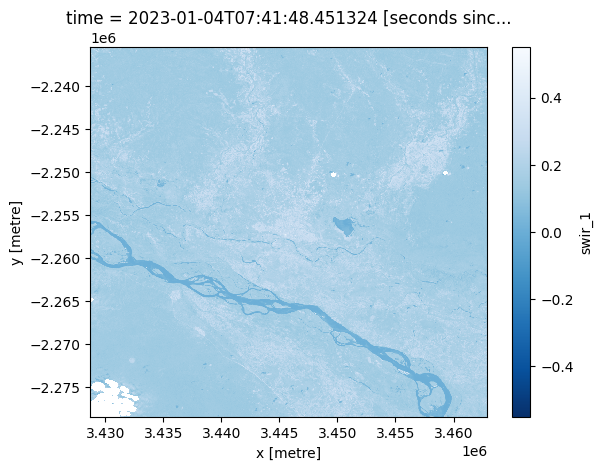

In [11]:
# plotting single band images
#selecting and plotting a single timestep
ds_preview = ds_list[2]  # first dataset (e.g., 2017)

# Select the first time step from swir_1 band
timestep = ds_preview.swir_1.isel(time=0)

# Plot the timestep
timestep.plot(cmap='Blues_r')


In [12]:
#combine the datasets
import xarray as xr

# Concatenate along the 'time' dimension
ds_merged = xr.concat(ds_list, dim='time')

# Sort by time just in case
ds_merged = ds_merged.sortby('time')

print(ds_merged)


<xarray.Dataset> Size: 2GB
Dimensions:      (time: 53, y: 1434, x: 1139)
Coordinates:
  * time         (time) datetime64[ns] 424B 2017-01-28T07:35:17.200061 ... 20...
  * y            (y) float64 11kB -2.235e+06 -2.235e+06 ... -2.278e+06
  * x            (x) float64 9kB 3.429e+06 3.429e+06 ... 3.463e+06 3.463e+06
    spatial_ref  int32 4B 6933
Data variables:
    red          (time, y, x) float32 346MB dask.array<chunksize=(1, 1434, 1139), meta=np.ndarray>
    green        (time, y, x) float32 346MB dask.array<chunksize=(1, 1434, 1139), meta=np.ndarray>
    blue         (time, y, x) float32 346MB dask.array<chunksize=(1, 1434, 1139), meta=np.ndarray>
    nir          (time, y, x) float32 346MB dask.array<chunksize=(1, 1434, 1139), meta=np.ndarray>
    swir_1       (time, y, x) float32 346MB dask.array<chunksize=(1, 1434, 1139), meta=np.ndarray>
    swir_2       (time, y, x) float32 346MB dask.array<chunksize=(1, 1434, 1139), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
   

In [17]:
print(ds_merged.time.values)

['2017-01-28T07:35:17.200061000' '2017-02-13T07:35:09.497636000'
 '2017-05-04T07:34:30.173805000' '2017-06-05T07:34:50.992059000'
 '2017-06-28T07:41:09.634864000' '2017-07-07T07:35:00.475026000'
 '2017-07-14T07:41:12.385286000' '2017-07-23T07:35:06.495497000'
 '2017-08-24T07:35:17.878966000' '2017-09-09T07:35:19.408929000'
 '2017-09-16T07:41:30.766453000' '2017-10-11T07:35:29.554404000'
 '2017-10-27T07:35:30.932417000' '2017-11-03T07:41:41.135427000'
 '2020-02-06T07:35:16.226717000' '2020-02-22T07:35:12.935766000'
 '2020-03-25T07:34:58.687847000' '2020-04-01T07:41:05.046494000'
 '2020-05-12T07:34:37.068331000' '2020-06-20T07:41:05.124808000'
 '2020-07-06T07:41:12.561906000' '2020-07-15T07:35:05.043406000'
 '2020-07-31T07:35:09.421690000' '2020-08-07T07:41:21.534353000'
 '2020-08-16T07:35:14.006267000' '2020-09-17T07:35:28.160381000'
 '2020-10-03T07:35:31.880186000' '2020-10-10T07:41:43.450730000'
 '2020-10-19T07:35:32.933300000' '2020-11-20T07:35:31.457209000'
 '2020-12-22T07:35:32.339

<xarray.DataArray 'swir_1' (y: 1434, x: 1139)> Size: 7MB
dask.array<getitem, shape=(1434, 1139), dtype=float32, chunksize=(1434, 1139), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 8B 2017-02-13T07:35:09.497636
  * y            (y) float64 11kB -2.235e+06 -2.235e+06 ... -2.278e+06
  * x            (x) float64 9kB 3.429e+06 3.429e+06 ... 3.463e+06 3.463e+06
    spatial_ref  int32 4B 6933
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


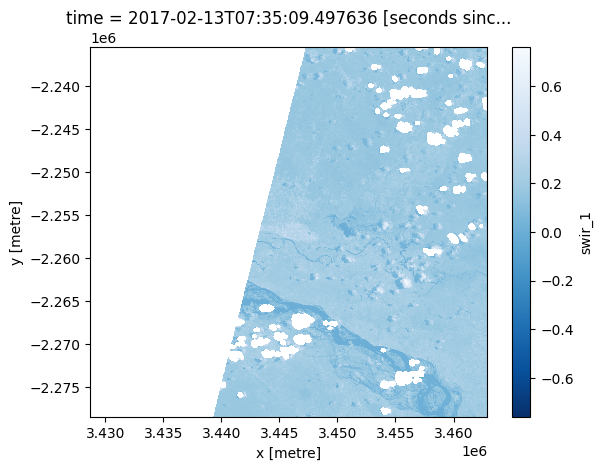

In [19]:
# Visual sanity check
first_timestep = ds_merged.swir_1.isel(time=1)

print(first_timestep)
first_timestep.plot(cmap='Blues_r')

In [20]:
#calculate tasseled cap wetness
def tasseled_cap_wetness(ds):
    coefficients = {
        'blue': 0.2630,
        'green': 0.1456,
        'red': 0.3379,
        'nir': 0.4556,
        'swir1': 0.6140,
        'swir2': 0.1126
    }
    
    wetness = (
        ds['blue'] * coefficients['blue'] +
        ds['green'] * coefficients['green'] +
        ds['red'] * coefficients['red'] +
        ds['nir'] * coefficients['nir'] +
        ds['swir_1'] * coefficients['swir1'] +
        ds['swir_2'] * coefficients['swir2']
    )
    
    return wetness
    
tcw = tasseled_cap_wetness(ds_merged)
print(tcw)

<xarray.DataArray (time: 53, y: 1434, x: 1139)> Size: 346MB
dask.array<add, shape=(53, 1434, 1139), dtype=float32, chunksize=(1, 1434, 1139), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 424B 2017-01-28T07:35:17.200061 ... 20...
  * y            (y) float64 11kB -2.235e+06 -2.235e+06 ... -2.278e+06
  * x            (x) float64 9kB 3.429e+06 3.429e+06 ... 3.463e+06 3.463e+06
    spatial_ref  int32 4B 6933


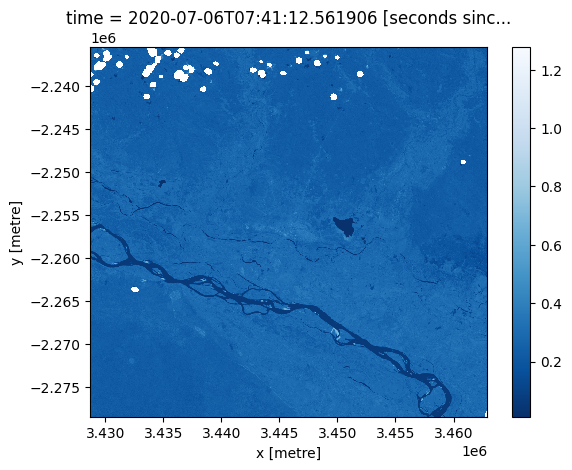

In [22]:
tcw.isel(time=20).plot(cmap='Blues_r')  # Plot time step

#### 2. Fractional Cover (FC)

#### 3. Masking using WOfS and TCW

#### 4. Stacking and classifying land type

#### 5. compare statistics: water inundation vs malaria incidence rate